# MASTER THESIS - PRINCIPAL COMPONENT ANALYSIS
***

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Files" data-toc-modified-id="Files-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Files</a></span></li></ul></li><li><span><a href="#Covariance-Matrix" data-toc-modified-id="Covariance-Matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Covariance Matrix</a></span></li><li><span><a href="#Eigen-Decomposition" data-toc-modified-id="Eigen-Decomposition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Eigen Decomposition</a></span></li><li><span><a href="#Transformation" data-toc-modified-id="Transformation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transformation</a></span></li><li><span><a href="#Inverse" data-toc-modified-id="Inverse-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Inverse</a></span></li><li><span><a href="#Error-Metrics" data-toc-modified-id="Error-Metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Error Metrics</a></span></li><li><span><a href="#Export" data-toc-modified-id="Export-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Export</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#PC-Loadings" data-toc-modified-id="PC-Loadings-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>PC Loadings</a></span></li><li><span><a href="#PC-Scores" data-toc-modified-id="PC-Scores-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>PC Scores</a></span></li><li><span><a href="#Goodness-of-Fit" data-toc-modified-id="Goodness-of-Fit-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Goodness of Fit</a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Correlation</a></span></li></ul></li></ul></div>

### Parameters
***

In [1]:
freq_all = ["day","week","month"]
freq = freq_all[0]

k = 3
pred_start = "2020-06-30"

print (f'Yield curve frequency is {freq}-wise.')
print (f'PCA will make use of {k} main components.')
print (f'PC-loadings and scores will be determined up to {pred_start}')

Yield curve frequency is day-wise.
PCA will make use of 3 main components.
PC-loadings and scores will be determined up to 2020-06-30


### Import
***

#### Packages

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [3]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:,.6f}'.format

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.pyplot import cm
import seaborn as sns


years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

%config InlineBackend.figure_format ="retina"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import sys, os
def blockPrint(): sys.stdout = open(os.devnull, 'w')
def enablePrint(): sys.stdout = sys.__stdout__ 
# blockPrint()

#### Files

In [6]:
# Cleaned spot data -------------------------------------------------------------------------
filepath_spot = "C:/Users/bernh/Jupyter scripts/04 Master Thesis/Data/02_cleaned/"
filename_spot = "spot_"+str(freq)+".csv"

spot = pd.read_csv(filepath_spot + filename_spot, index_col = 0)
spot.columns.name = "spot_"+str(freq)
spot.index = pd.to_datetime(spot.index)

# List of used tenors -----------------------------------------------------------------------
filepath_tenors = "C:/Users/bernh/Jupyter scripts/04 Master Thesis/Data/01_input/"
filename_tenors = "tenors.csv"

tenors_df = pd.read_csv(filepath_tenors+filename_tenors, index_col = 0)
tenors_str = tenors_df["MAT_STR"]
tenors_num = tenors_df["MAT_NUM"]

instances = spot.shape[0]

In [7]:
spot = spot[spot.index < pred_start]
spot.tail()

spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2020-06-23,-0.571026,-0.582925,-0.609976,-0.657291,-0.679066,-0.672873,-0.644372,-0.600931,-0.549098,-0.493845,...,-0.289817,-0.210083,-0.144997,-0.092010,-0.048588,-0.012620,0.017540,0.043138,0.065111,0.084167
2020-06-24,-0.575772,-0.587039,-0.612285,-0.655366,-0.673562,-0.665002,-0.635274,-0.591482,-0.539894,-0.485250,...,-0.284683,-0.206510,-0.142726,-0.090807,-0.048261,-0.013018,0.016535,0.041618,0.063150,0.081823
2020-06-25,-0.592146,-0.606322,-0.636927,-0.688952,-0.713917,-0.710264,-0.683931,-0.642359,-0.592110,-0.538170,...,-0.337249,-0.258235,-0.193587,-0.140876,-0.097640,-0.061803,-0.031743,-0.006226,0.015681,0.034681
2020-06-26,-0.589734,-0.608113,-0.643379,-0.696094,-0.717403,-0.709829,-0.680724,-0.637772,-0.587330,-0.534059,...,-0.339294,-0.263516,-0.201688,-0.151350,-0.110090,-0.075904,-0.047234,-0.022898,-0.002007,0.016112
2020-06-29,-0.574737,-0.598704,-0.639875,-0.693476,-0.711434,-0.701077,-0.670680,-0.627554,-0.577443,-0.524525,...,-0.327855,-0.249337,-0.184337,-0.130823,-0.086610,-0.049783,-0.018794,0.007565,0.030220,0.049882


<img src="../Images/1_data_matrix.PNG">

### Covariance Matrix
***
- Import clean yield data
- Calculate covariance matrix in <code>cov_matrix</code>
- Calculate correlation matrix in <code>corr_matrix</code>

<img src="../Images/2_Cov.PNG">

In [8]:
# Covariance Matrix ----------------------------------------------------------------------
cov_data = np.array(spot).T

cov_matrix = np.cov(cov_data, bias = True)
cov_matrix = pd.DataFrame(data = cov_matrix)
cov_matrix = pd.DataFrame(data = cov_matrix.values, 
                          columns = list(tenors_str), 
                          index = list(tenors_str))

# Correlation Matrix ---------------------------------------------------------------------
corr_matrix = pd.DataFrame(data = (spot[spot.index < pred_start]).corr().values,
                           columns = list(tenors_str), 
                           index = list(tenors_str))

cov_matrix.columns.name = "COV"
corr_matrix.columns.name = "CORR"

In [9]:
print ("Covariance matrix: XT * X")
print (f'- Row: Features f = {cov_matrix.shape[0]}')
print (f'- Col: Features f = {cov_matrix.shape[1]}')

corr_matrix

Covariance matrix: XT * X
- Row: Features f = 22
- Col: Features f = 22


CORR,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
3M,1.000000,0.999126,0.995800,0.982760,0.964874,0.944844,0.924335,0.904380,0.885611,0.868416,...,0.818237,0.804029,0.795846,0.792479,0.792767,0.795691,0.800411,0.806258,0.812719,0.819413
6M,0.999126,1.000000,0.998038,0.985994,0.968565,0.948717,0.928219,0.908169,0.889243,0.871859,...,0.820907,0.806395,0.797981,0.794450,0.794632,0.797497,0.802195,0.808049,0.814539,0.821277
1Y,0.995800,0.998038,1.000000,0.993832,0.979984,0.962529,0.943719,0.924889,0.906851,0.890112,...,0.840327,0.825947,0.817520,0.813884,0.813898,0.816550,0.820998,0.826570,0.832752,0.839161
2Y,0.982760,0.985994,0.993832,1.000000,0.995683,0.985481,0.972275,0.957823,0.943225,0.929193,...,0.885458,0.872331,0.864471,0.860927,0.860691,0.862843,0.866602,0.871343,0.876585,0.881973
3Y,0.964874,0.968565,0.979984,0.995683,1.000000,0.996918,0.989496,0.979729,0.968922,0.957948,...,0.921368,0.909828,0.902754,0.899434,0.899028,0.900727,0.903830,0.907770,0.912108,0.916520
4Y,0.944844,0.948717,0.962529,0.985481,0.996918,1.000000,0.997762,0.992307,0.985065,0.977019,...,0.947499,0.937587,0.931351,0.928314,0.927799,0.929114,0.931640,0.934869,0.938405,0.941957
5Y,0.924335,0.928219,0.943719,0.972275,0.989496,0.997762,1.000000,0.998352,0.994314,0.988940,...,0.966036,0.957704,0.952307,0.949581,0.949004,0.949995,0.952016,0.954615,0.957440,0.960229
6Y,0.904380,0.908169,0.924889,0.957823,0.979729,0.992307,0.998352,1.000000,0.998779,0.995787,...,0.978928,0.972086,0.967501,0.965097,0.964493,0.965210,0.966786,0.968825,0.971013,0.973119
7Y,0.885611,0.889243,0.906851,0.943225,0.968922,0.985065,0.994314,0.998779,1.000000,0.999097,...,0.987662,0.982198,0.978380,0.976298,0.975691,0.976177,0.977362,0.978901,0.980518,0.982011
8Y,0.868416,0.871859,0.890112,0.929193,0.957948,0.977019,0.988940,0.995787,0.999097,1.000000,...,0.993359,0.989145,0.986040,0.984267,0.983677,0.983970,0.984813,0.985909,0.987018,0.987963


### Eigen Decomposition
***
- Performing eigen-decomposition of covariance matrix on <code>eig</code>
- Store list with number of pc's for labeling in <code>pc_index</code>
- Extract eigen value explainability ratio in <code>omega_df</code>
- Extract eigen vector loadings in <code>W</code> and reduce them to k components in <code>W_k</code>

<img src="../Images/3_pc_loadings.PNG">

In [10]:
eig = np.linalg.eig(cov_matrix)

pc_index = list(["PC_"+str(i) for i in range(1, eig[0].shape[0]+1)])

# Eigenvalues --------------------------------------------------------------------------------------------
omega = pd.DataFrame(eig[0].real, columns = ["EIG_VAL"], index = pc_index)
omega["EIG_VAL_REL"] = omega["EIG_VAL"].apply(lambda x: x/omega["EIG_VAL"].sum())
omega["EIG_VAL_CUM"] = omega["EIG_VAL_REL"].cumsum()

# Eigenvectors -------------------------------------------------------------------------------------------
W = pd.DataFrame(eig[1].real, index = list(tenors_str), columns = pc_index)
W_k = W.iloc[:,:k]
W.columns.name = "W"
W_k.columns.name = "W_k"

In [11]:
print ("Eigen values: Lambda")
print (f'- Row: Explained variance pc = {omega.shape[0]}')
print (f'- Col: One-dimension scalar = {omega.shape[1]}')

omega

Eigen values: Lambda
- Row: Explained variance pc = 22
- Col: One-dimension scalar = 3


,EIG_VAL,EIG_VAL_REL,EIG_VAL_CUM
PC_1,51.553919,0.947656,0.947656
PC_2,2.676528,0.049200,0.996856
PC_3,0.138251,0.002541,0.999397
PC_4,0.019355,0.000356,0.999753
PC_5,0.009678,0.000178,0.999931
PC_6,0.002887,0.000053,0.999984
PC_7,0.000817,0.000015,0.999999
PC_8,0.000059,0.000001,1.000000
PC_9,0.000011,0.000000,1.000000
PC_10,0.000001,0.000000,1.000000


In [12]:
print ("Eigen vector loadings: W")
print (f'- Row: Features f = {W.shape[0]}')
print (f'- Col: Principal components pc = {W.shape[1]}')

W

Eigen vector loadings: W
- Row: Features f = 22
- Col: Principal components pc = 22


W,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22
3M,-0.191016,0.401397,-0.406297,0.280560,-0.282758,-0.577858,0.345270,-0.114486,-0.096684,0.049923,...,0.002458,0.001005,-0.000301,0.000062,0.000012,0.000005,-0.000013,0.000008,0.000006,-0.000007
6M,-0.196168,0.410829,-0.330564,0.191393,-0.130887,0.272710,-0.548096,0.365820,0.289817,-0.173422,...,-0.009789,-0.004046,0.001241,-0.000270,-0.000053,-0.000021,0.000055,-0.000034,-0.000027,0.000030
1Y,-0.203737,0.392562,-0.154828,-0.050959,0.214991,0.526439,0.041408,-0.426717,-0.391085,0.299883,...,0.024298,0.010633,-0.003494,0.000839,0.000175,0.000071,-0.000179,0.000110,0.000085,-0.000096
2Y,-0.213941,0.315111,0.102784,-0.261729,0.385076,0.062882,0.431346,-0.027101,0.287491,-0.438718,...,-0.096365,-0.050509,0.019829,-0.006000,-0.001459,-0.000596,0.001419,-0.000894,-0.000640,0.000735
3Y,-0.219937,0.233291,0.237301,-0.248443,0.234797,-0.199382,0.045419,0.346994,0.187333,0.205374,...,0.289529,0.197337,-0.098019,0.038704,0.011563,0.004943,-0.010575,0.006918,0.004395,-0.005029
4Y,-0.223124,0.158950,0.295226,-0.166638,0.043495,-0.236860,-0.209798,0.197901,-0.187808,0.314010,...,-0.399263,-0.416651,0.287028,-0.155085,-0.060633,-0.028102,0.051380,-0.035735,-0.018806,0.020290
5Y,-0.224479,0.093926,0.306361,-0.071255,-0.104750,-0.166103,-0.254334,-0.055571,-0.284544,0.003318,...,0.041727,0.336706,-0.426960,0.354255,0.200774,0.104901,-0.153580,0.119297,0.043571,-0.037052
6Y,-0.224674,0.038000,0.289042,0.018915,-0.191633,-0.062130,-0.175011,-0.209891,-0.148504,-0.235313,...,0.307339,0.172131,0.156617,-0.379117,-0.401606,-0.245438,0.259217,-0.255804,-0.026570,-0.027434
7Y,-0.224158,-0.009587,0.255113,0.097031,-0.221636,0.035282,-0.052501,-0.234034,0.047631,-0.249099,...,0.079665,-0.254840,0.282921,-0.013842,0.426555,0.304439,-0.168615,0.350519,-0.118746,0.270647
8Y,-0.223231,-0.049705,0.212404,0.160556,-0.206886,0.108286,0.063743,-0.164003,0.188199,-0.104558,...,-0.198411,-0.241962,-0.095159,0.305190,-0.129580,-0.010848,-0.143004,-0.314776,0.302416,-0.506307


In [13]:
print ("Selected eigen vector loadings: W_k")
print (f'- Row: Features f = {W_k.shape[0]}')
print (f'- Col: Principal components selected k = {W_k.shape[1]}')

W_k

Selected eigen vector loadings: W_k
- Row: Features f = 22
- Col: Principal components selected k = 3


W_k,PC_1,PC_2,PC_3
3M,-0.191016,0.401397,-0.406297
6M,-0.196168,0.410829,-0.330564
1Y,-0.203737,0.392562,-0.154828
2Y,-0.213941,0.315111,0.102784
3Y,-0.219937,0.233291,0.237301
4Y,-0.223124,0.158950,0.295226
5Y,-0.224479,0.093926,0.306361
6Y,-0.224674,0.038000,0.289042
7Y,-0.224158,-0.009587,0.255113
8Y,-0.223231,-0.049705,0.212404


### Transformation
***
- Multiply principals component loadings <code>W</code> with yield data <code>spot</code> in <code>T</code>
- Keep only k components in <code>T_k</code> in order to reduce dimensions

<img src="../Images/4_pc_transform.PNG">

In [14]:
T = np.matrix(spot) * np.matrix(W)
T = pd.DataFrame(data = T, 
                 index = pd.to_datetime(spot.index), 
                 columns = pc_index)


T_k = T.iloc[:,:k]
T.columns.name = "T"
T_k.columns.name = "T_k"

In [15]:
print ("Eigen vectors transformed: T_k")
print (f'- Row: Observations n = {T_k.shape[0]}')
print (f'- Col: Principal components selected k = {T_k.shape[1]}')

T_k.head()

Eigen vectors transformed: T_k
- Row: Observations n = 3957
- Col: Principal components selected k = 3


T_k,PC_1,PC_2,PC_3
2005-01-03,-16.390871,-3.436138,-1.401473
2005-01-04,-16.377627,-3.406680,-1.266444
2005-01-05,-16.481006,-3.409532,-1.240380
2005-01-06,-16.257201,-3.402436,-1.285503
2005-01-07,-16.121809,-3.382892,-1.292944


### Inverse
***
- Get inverse matrix of principal component loadings in <code>W_inv</code>
- Keep only k transformed principal component loadings <code>W_k_inv</code>
- Multiply <code>T_k</code> with <code>W_k_inv</code> to receive PCA dimensionality reduced yields in <code>X_k</code>

<img src="../Images/5_pc_reverse_transform.PNG">

In [16]:
W_inv = pd.DataFrame (data = np.linalg.inv(np.matrix(W)),
                      columns = list(tenors_str),
                      index = pc_index)

W_inv.columns.name = "W_inv"

W_k_inv = W_inv.copy()
W_k_inv = W_k_inv.iloc[:k,:]
W_k_inv.columns.name = "W_k_inv"

In [17]:
print ("Inverse of all eigen vector loadings: W_inv")
print (f'- Row: Principal components pc = {W_inv.shape[0]}')
print (f'- Col: Features f = {W_inv.shape[1]}')

W_inv

Inverse of all eigen vector loadings: W_inv
- Row: Principal components pc = 22
- Col: Features f = 22


W_inv,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
PC_1,-0.191016,-0.196168,-0.203737,-0.213941,-0.219937,-0.223124,-0.224479,-0.224674,-0.224158,-0.223231,...,-0.218300,-0.215911,-0.213742,-0.211792,-0.210035,-0.208440,-0.206979,-0.205630,-0.204373,-0.203196
PC_2,0.401397,0.410829,0.392562,0.315111,0.233291,0.158950,0.093926,0.038000,-0.009587,-0.049705,...,-0.151478,-0.176450,-0.189728,-0.194424,-0.192952,-0.187152,-0.178405,-0.167735,-0.155891,-0.143414
PC_3,-0.406297,-0.330564,-0.154828,0.102784,0.237301,0.295226,0.306361,0.289042,0.255113,0.212404,...,0.033683,-0.036932,-0.090780,-0.129436,-0.155580,-0.172050,-0.181405,-0.185772,-0.186824,-0.185823
PC_4,0.280560,0.191393,-0.050959,-0.261729,-0.248443,-0.166638,-0.071255,0.018915,0.097031,0.160556,...,0.266736,0.245417,0.190380,0.113291,0.023751,-0.071037,-0.166064,-0.258096,-0.345225,-0.426479
PC_5,-0.282758,-0.130887,0.214991,0.385076,0.234797,0.043495,-0.104750,-0.191633,-0.221636,-0.206886,...,0.049328,0.174103,0.250969,0.272294,0.241176,0.165690,0.055457,-0.080198,-0.233097,-0.396503
PC_6,-0.577858,0.272710,0.526439,0.062882,-0.199382,-0.236860,-0.166103,-0.062130,0.035282,0.108286,...,0.134308,0.055500,-0.030631,-0.098863,-0.135738,-0.136149,-0.100253,-0.031198,0.066426,0.187552
PC_7,0.345270,-0.548096,0.041408,0.431346,0.045419,-0.209798,-0.254334,-0.175011,-0.052501,0.063743,...,0.196698,0.110216,-0.002247,-0.099308,-0.157954,-0.169017,-0.132191,-0.052122,0.064258,0.209395
PC_8,-0.114486,0.365820,-0.426717,-0.027101,0.346994,0.197901,-0.055571,-0.209891,-0.234034,-0.164003,...,0.237825,0.255153,0.155854,0.005528,-0.133993,-0.218258,-0.221604,-0.133764,0.044625,0.306086
PC_9,-0.096684,0.289817,-0.391085,0.287491,0.187333,-0.187808,-0.284544,-0.148504,0.047631,0.188199,...,-0.019075,-0.207656,-0.255665,-0.165333,-0.000614,0.159594,0.246766,0.212280,0.028134,-0.316282
PC_10,0.049923,-0.173422,0.299883,-0.438718,0.205374,0.314010,0.003318,-0.235313,-0.249099,-0.104558,...,0.254877,0.050971,-0.164326,-0.243479,-0.162924,0.013517,0.184067,0.245638,0.114100,-0.267995


In [18]:
print ("Inverse of selected eigen vector loadings: W_k_inv")
print (f'- Row: Principal components selected k = {W_k_inv.shape[0]}')
print (f'- Col: Features_f = {W_k_inv.shape[1]}')

W_k_inv

Inverse of selected eigen vector loadings: W_k_inv
- Row: Principal components selected k = 3
- Col: Features_f = 22


W_k_inv,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
PC_1,-0.191016,-0.196168,-0.203737,-0.213941,-0.219937,-0.223124,-0.224479,-0.224674,-0.224158,-0.223231,...,-0.218300,-0.215911,-0.213742,-0.211792,-0.210035,-0.208440,-0.206979,-0.205630,-0.204373,-0.203196
PC_2,0.401397,0.410829,0.392562,0.315111,0.233291,0.158950,0.093926,0.038000,-0.009587,-0.049705,...,-0.151478,-0.176450,-0.189728,-0.194424,-0.192952,-0.187152,-0.178405,-0.167735,-0.155891,-0.143414
PC_3,-0.406297,-0.330564,-0.154828,0.102784,0.237301,0.295226,0.306361,0.289042,0.255113,0.212404,...,0.033683,-0.036932,-0.090780,-0.129436,-0.155580,-0.172050,-0.181405,-0.185772,-0.186824,-0.185823


In [19]:
X_k = np.matrix(T_k) * np.matrix(W_k_inv)
X_k = pd.DataFrame(data = X_k, 
                   columns = list(tenors_str),
                   index = spot.index)

X_k.columns.name = "X_k"

In [20]:
print ("Back-transformed from PC scores to yields in original dimensionalty: X_k")
print (f'- Row: Observations n = {X_k.shape[0]}')
print (f'- Col: Features f = {X_k.shape[1]}')

X_k.head()

Back-transformed from PC scores to yields in original dimensionalty: X_k
- Row: Observations n = 3957
- Col: Features f = 22


X_k,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,...,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2005-01-03,2.321079,2.266978,2.207519,2.279869,2.470775,2.697275,2.927310,3.146936,3.349559,3.532071,...,4.051420,4.197033,4.282581,4.320932,4.323708,4.300710,4.259822,4.207163,4.147348,4.083770
2005-01-04,2.275512,2.231846,2.195478,2.300197,2.506776,2.738866,2.968471,3.184109,3.380755,3.556331,...,4.048615,4.183989,4.261903,4.294922,4.294235,4.269205,4.227331,4.174414,4.114822,4.051762
2005-01-05,2.283524,2.242338,2.211385,2.324094,2.535033,2.769174,2.999395,3.214761,3.410605,3.585086,...,4.072493,4.205850,4.282175,4.313997,4.312443,4.286803,4.244508,4.191308,4.131525,4.068334
2005-01-06,2.261955,2.216266,2.175560,2.273811,2.476758,2.707044,2.935998,3.151705,3.348858,3.525189,...,4.021041,4.157942,4.237088,4.271058,4.271087,4.246588,4.205105,4.152479,4.093109,4.030225
2005-01-07,2.246962,2.200196,2.156800,2.250239,2.449774,2.677745,2.905161,3.119878,3.316423,3.492413,...,3.988274,4.125536,4.205116,4.239547,4.240037,4.215990,4.174945,4.122743,4.063782,4.001294


### Error Metrics
***

In [21]:
# RMSE ----------------------------------------------------------------------------------
se = (X_k - spot)**2
rmse = pd.DataFrame(data = se.T.mean(), columns = ["RMSE"])**0.5
rmse.index = pd.to_datetime(rmse.index)

# MAE -----------------------------------------------------------------------------------
ae = abs(X_k - spot)
mae = pd.DataFrame(data = ae.T.mean(), columns = ["MAE"])
mae.index = pd.to_datetime(mae.index)

In [22]:
# Worst fitting days
rmse.sort_values(by = "RMSE", ascending = False)

,RMSE
2005-01-04,0.173824
2005-01-03,0.172950
2005-01-05,0.172604
2010-05-27,0.170978
2009-08-28,0.170961
...,...
2008-12-22,0.013852
2008-12-19,0.012907
2009-01-02,0.012573
2008-12-31,0.011237


In [23]:
rmse_year = se.copy()
rmse_year["year"] = rmse_year.index.year
rmse_year = rmse_year.groupby("year").mean()**0.5

rmse_year.index.name = None
rmse_year.columns.name = "sq_err"
rmse_year.iloc[:5,:5]

sq_err,3M,6M,1Y,2Y,3Y
2005,0.166549,0.084586,0.042469,0.117979,0.111275
2006,0.234009,0.076365,0.103623,0.169352,0.121768
2007,0.150573,0.064776,0.059981,0.115354,0.089365
2008,0.140047,0.101370,0.070339,0.121487,0.088713
2009,0.148479,0.119927,0.041439,0.151445,0.151168


In [24]:
rmse.mean()

RMSE   0.102073
dtype: float64

In [25]:
mae.mean()

MAE   0.085748
dtype: float64

### Export
***

In [26]:
filepath_out = "C:/Users/bernh/Jupyter scripts/04 Master Thesis/Data/03_pca/"

W_k_inv.to_csv(filepath_out+"W_k_inv_" + str(freq)+".csv")
W_k.to_csv(filepath_out+"W_k_" + str(freq)+".csv")
T_k.to_csv(filepath_out+"T_k_" + str(freq)+".csv")
X_k.to_csv(filepath_out+"X_k_" + str(freq)+".csv")

### Visualization
***

#### PC Loadings

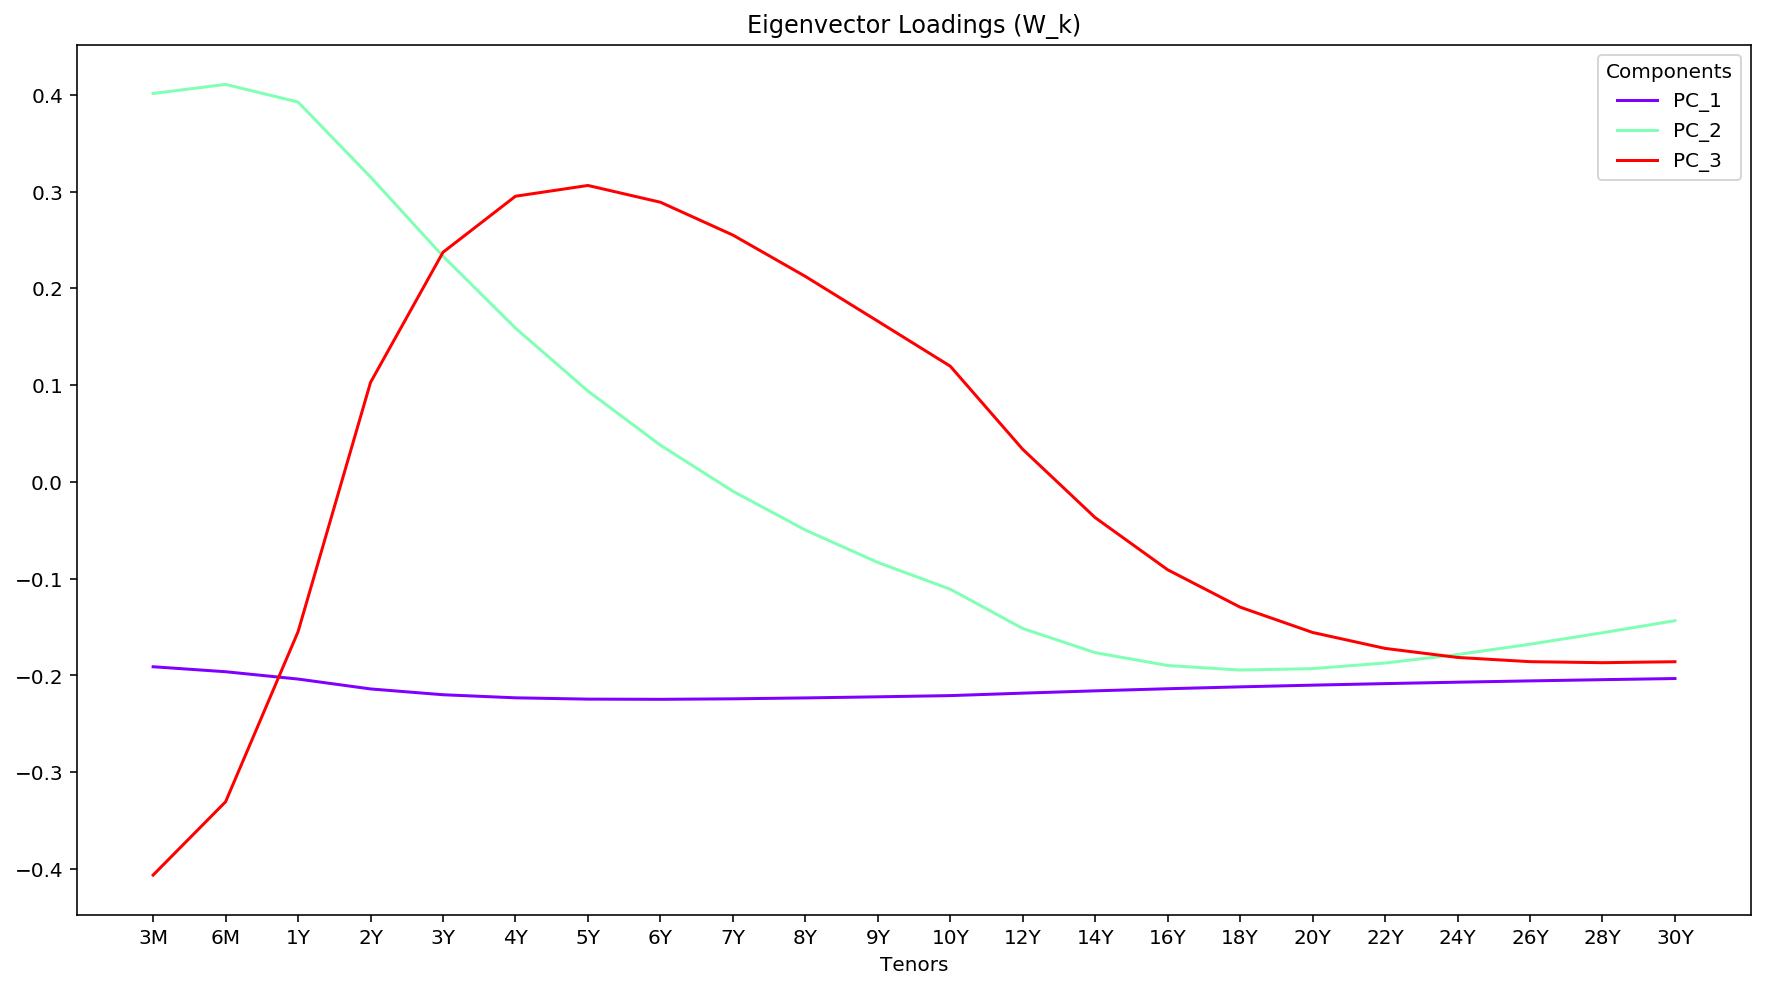

In [27]:
color = cm.rainbow(np.linspace(0,1,3))
pcs = ["PC_1","PC_2","PC_3"]

fig_1 = plt.figure(figsize = [15,8])

for i,c in zip(pcs, color):
    plt.plot(W_k[i],c = c)

plt.title ("Eigenvector Loadings (W_k)")
plt.xlabel ("Tenors")
plt.legend(title = "Components")

plt.show()

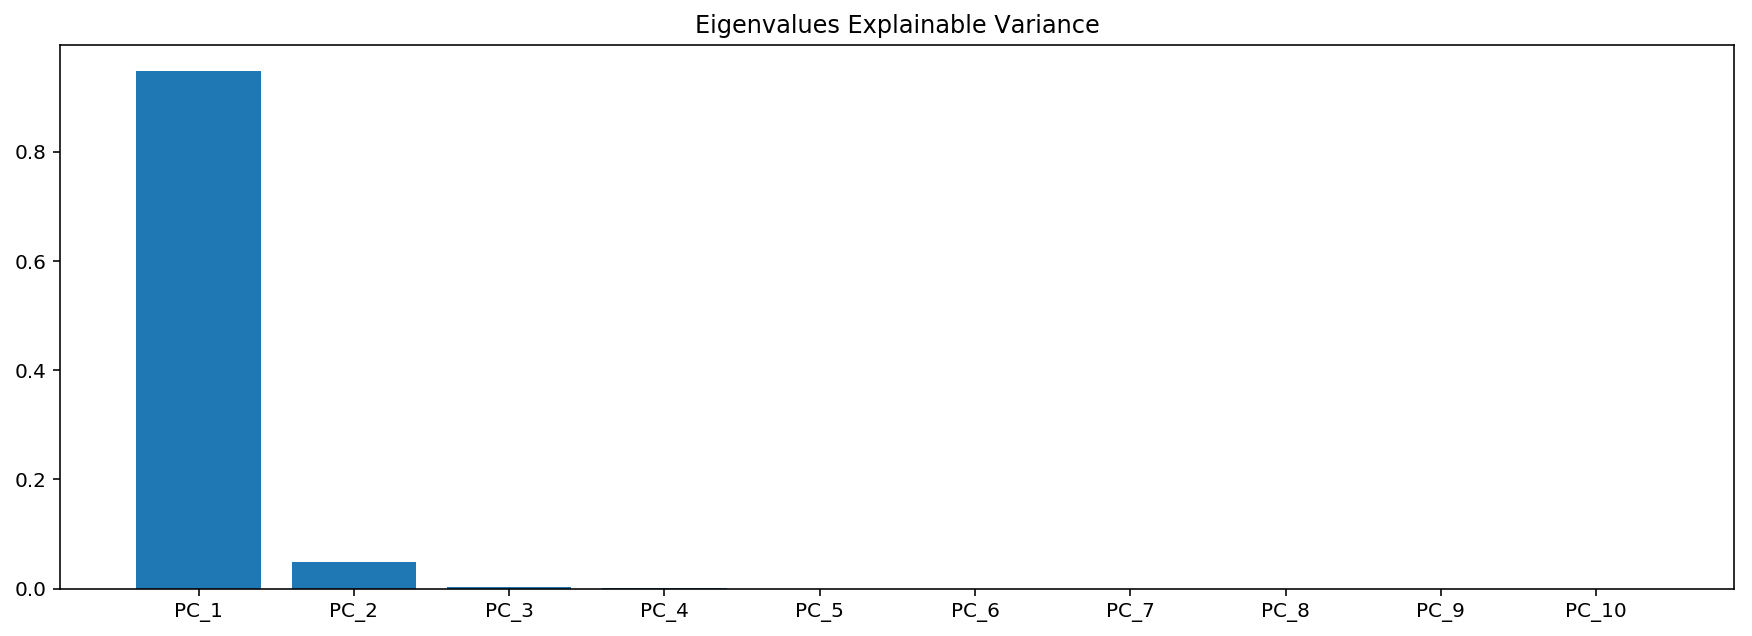

In [28]:
fig_2 = plt.figure(figsize = [15,5])

plt.bar(omega.index[:10], omega["EIG_VAL_REL"][:10])
plt.title ("Eigenvalues Explainable Variance")
plt.show()

#### PC Scores

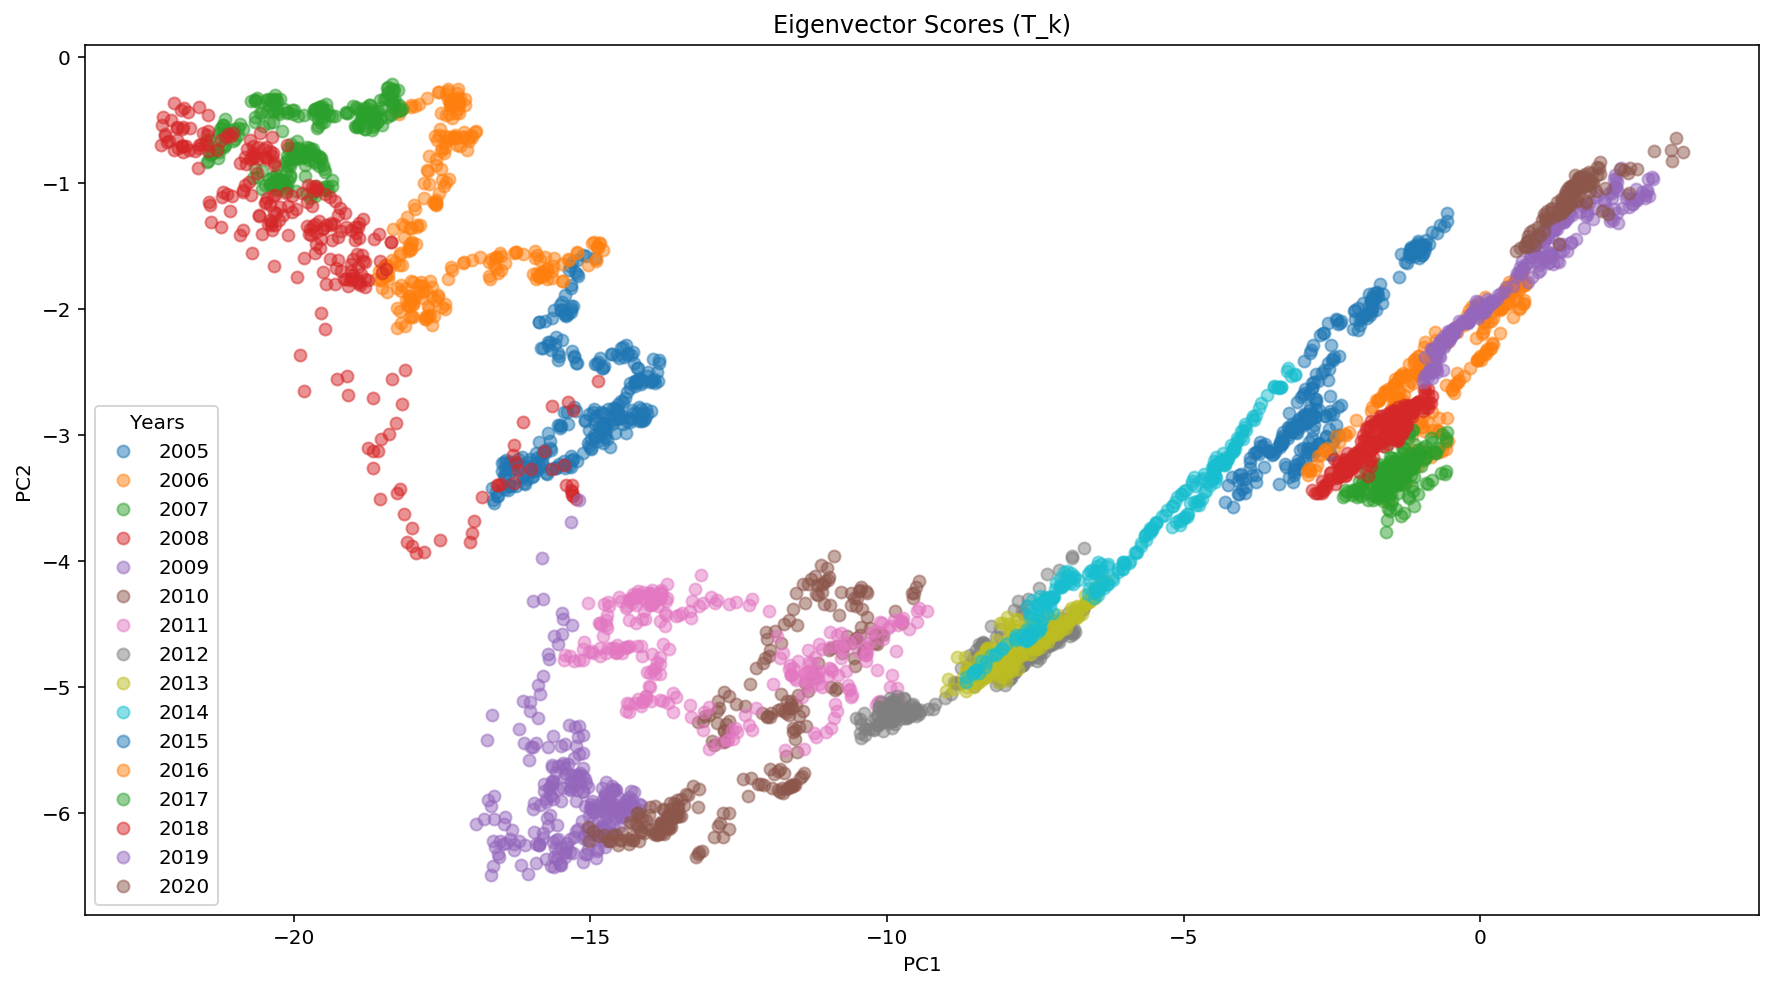

In [29]:
# Prepare data for visualization
T_k_viz = T_k.copy()
T_k_viz["Year"] = pd.DatetimeIndex(T_k_viz.index).year
T_k_viz = T_k_viz.groupby("Year")


# Create chart
fig_2 = plt.figure(figsize = [15,8])

for label, group in T_k_viz:
    plt.plot(group["PC_1"], 
             group["PC_2"], 
             marker = "o", 
             linestyle = "",
             alpha = 0.5,
             label=label)


# Format chart
plt.title ("Eigenvector Scores (T_k)")
plt.xlabel ("PC1")
plt.ylabel ("PC2")
plt.legend(title = "Years")

plt.show()

In [30]:
scaler = StandardScaler()

pc_1 = scaler.fit_transform(T_k["PC_1"].values.reshape(-1, 1))*-1
pc_2 = scaler.fit_transform(T_k["PC_1"].values.reshape(-1, 1))*-1
pc_3 = scaler.fit_transform(T_k["PC_1"].values.reshape(-1, 1))

lvl_factor = scaler.fit_transform(spot["10Y"].values.reshape(-1, 1))
slope_factor = scaler.fit_transform((spot["10Y"] - spot["6M"]).values.reshape(-1, 1))
curve_factor = scaler.fit_transform((spot["6M"] + spot["10Y"] - 2*spot["5Y"]).values.reshape(-1, 1))

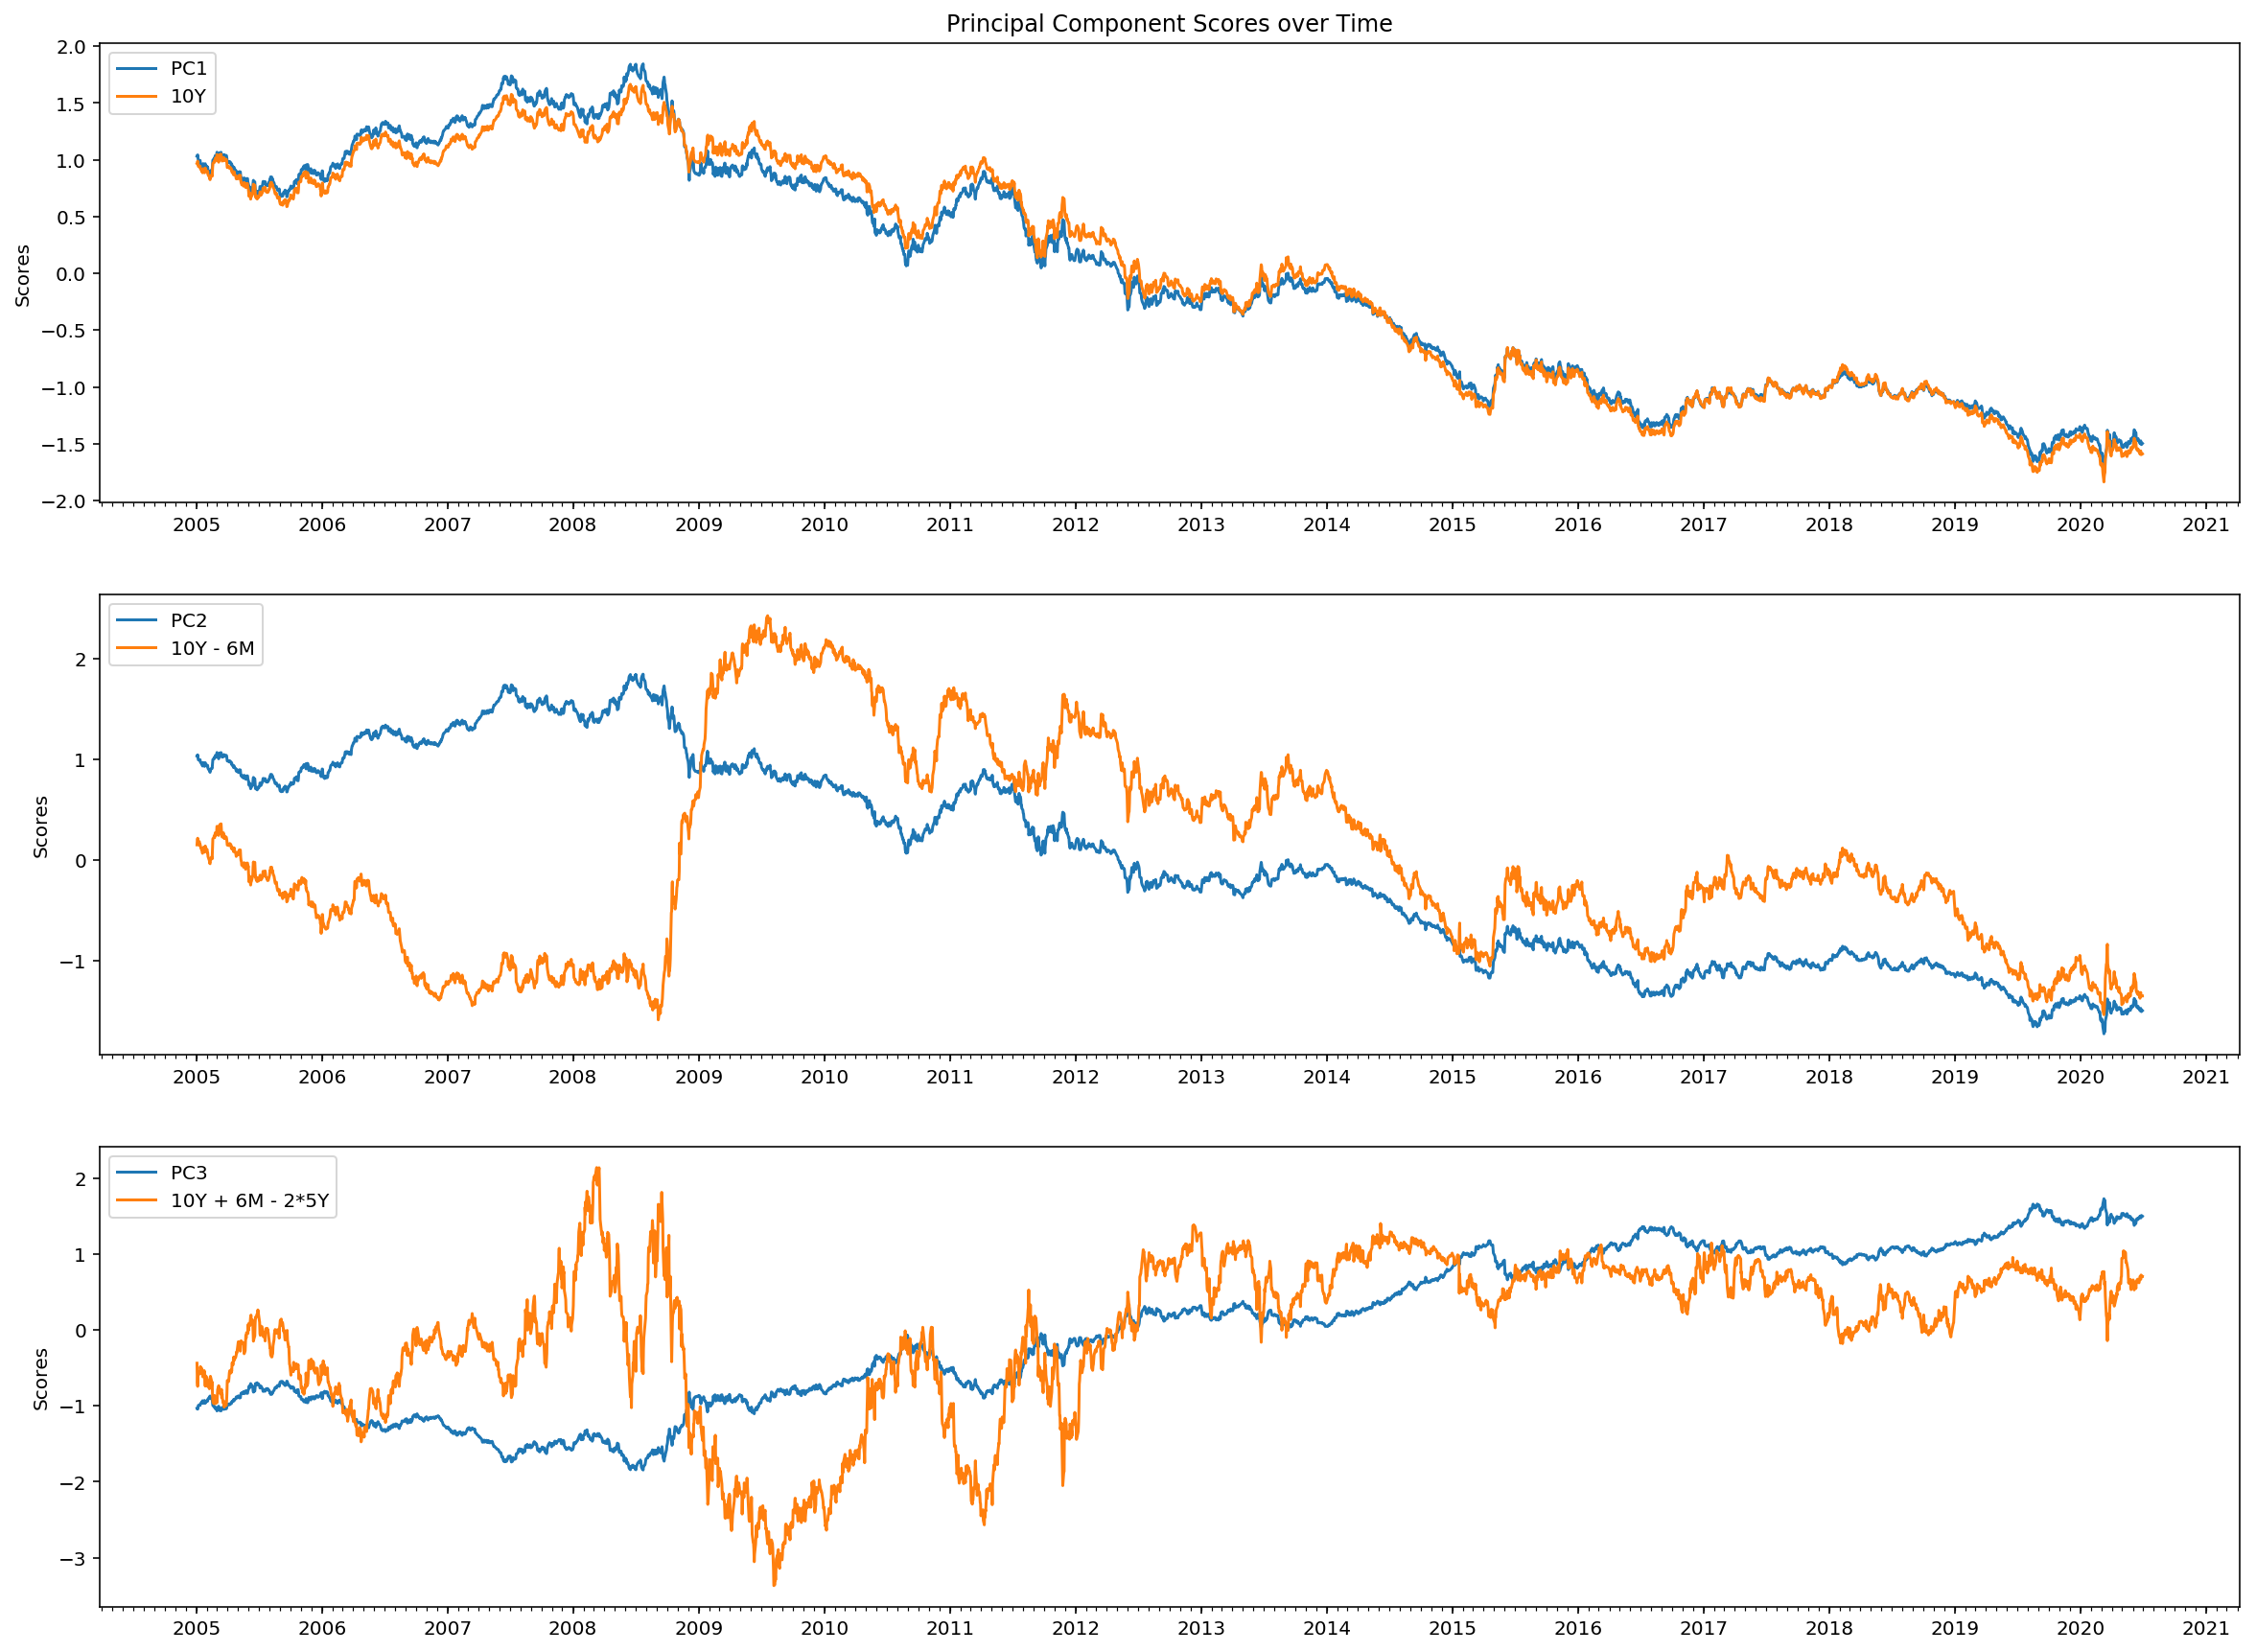

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (20,15))

# Plots ---------------------------------------------------------------------------
ax[0].plot(T_k.index, pc_1, label = "PC1")
ax[0].plot(T_k.index, lvl_factor, label = "10Y")

ax[1].plot(T_k.index, pc_2, label = "PC2")
ax[1].plot(T_k.index, slope_factor, label = "10Y - 6M")

ax[2].plot(T_k.index, pc_3, label = "PC3")
ax[2].plot(T_k.index, curve_factor, label = "10Y + 6M - 2*5Y")


# Format chart --------------------------------------------------------------------
ax[0].set_title ("Principal Component Scores over Time")

for i in range (3):
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].xaxis.set_major_locator(years)
    ax[i].xaxis.set_minor_locator(months)
    
    ax[i].set_ylabel ("Scores")
    ax[i].legend(loc = "upper left")

plt.show()

#### Goodness of Fit

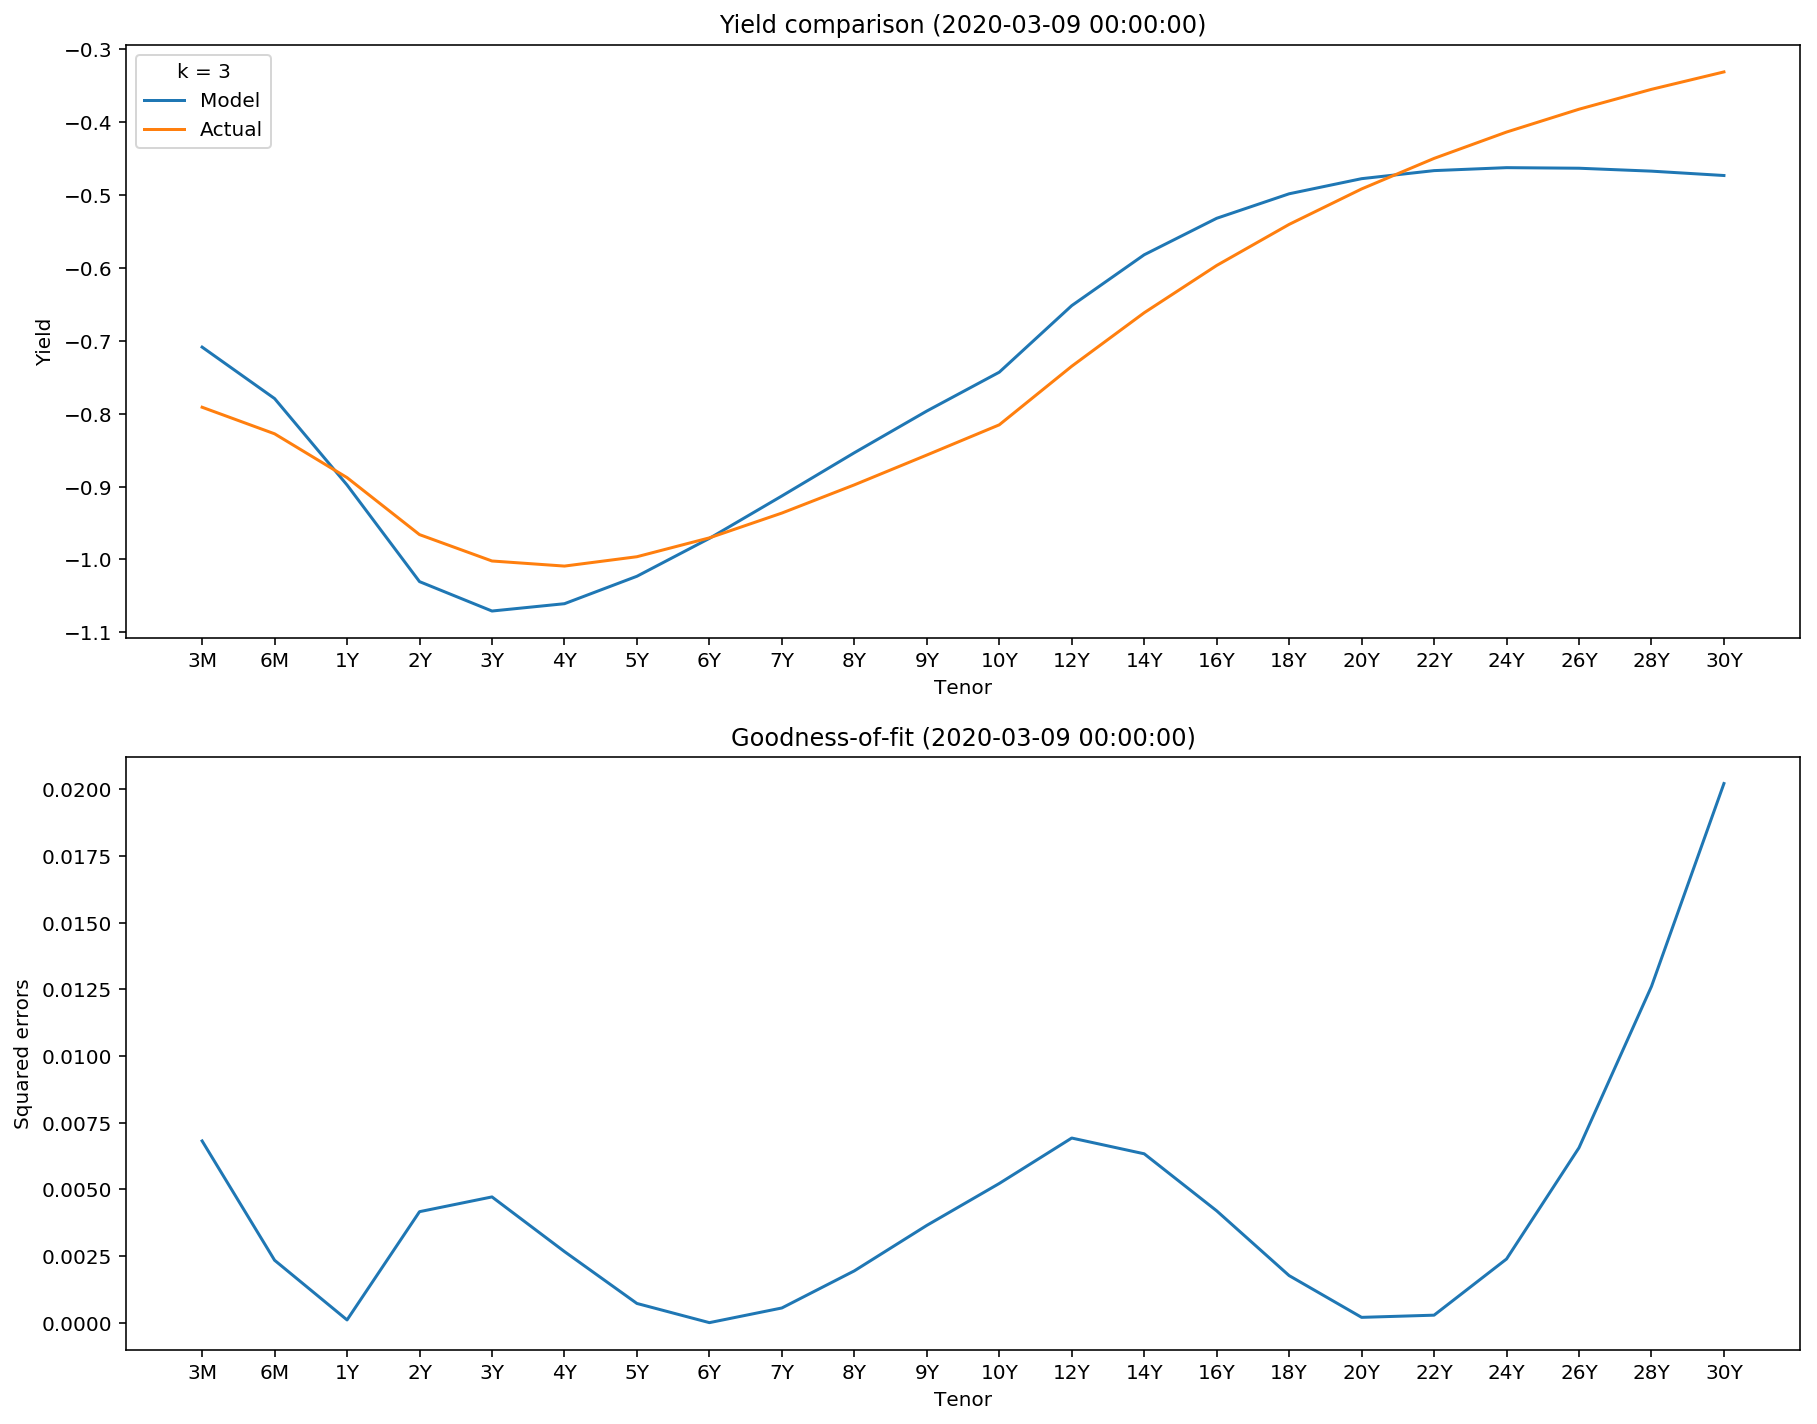

In [32]:
chart_date = spot.index[round(instances*0.98)]
#chart_date = "2008-06-06"

fig_3, ax = plt.subplots(2, 1, figsize = (15,12))

ax[0].plot(X_k.loc[chart_date,:], label ="Model")
ax[0].plot(spot.loc[chart_date,:], label = "Actual")
ax[1].plot(se.loc[chart_date,:])

ax[0].set_xlabel("Tenor")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield comparison ({chart_date})")

ax[1].set_xlabel("Tenor")
ax[1].set_ylabel("Squared errors")
ax[1].set_title(f"Goodness-of-fit ({chart_date})")

ax[0].legend(title = "k = "+str(k))
plt.show()

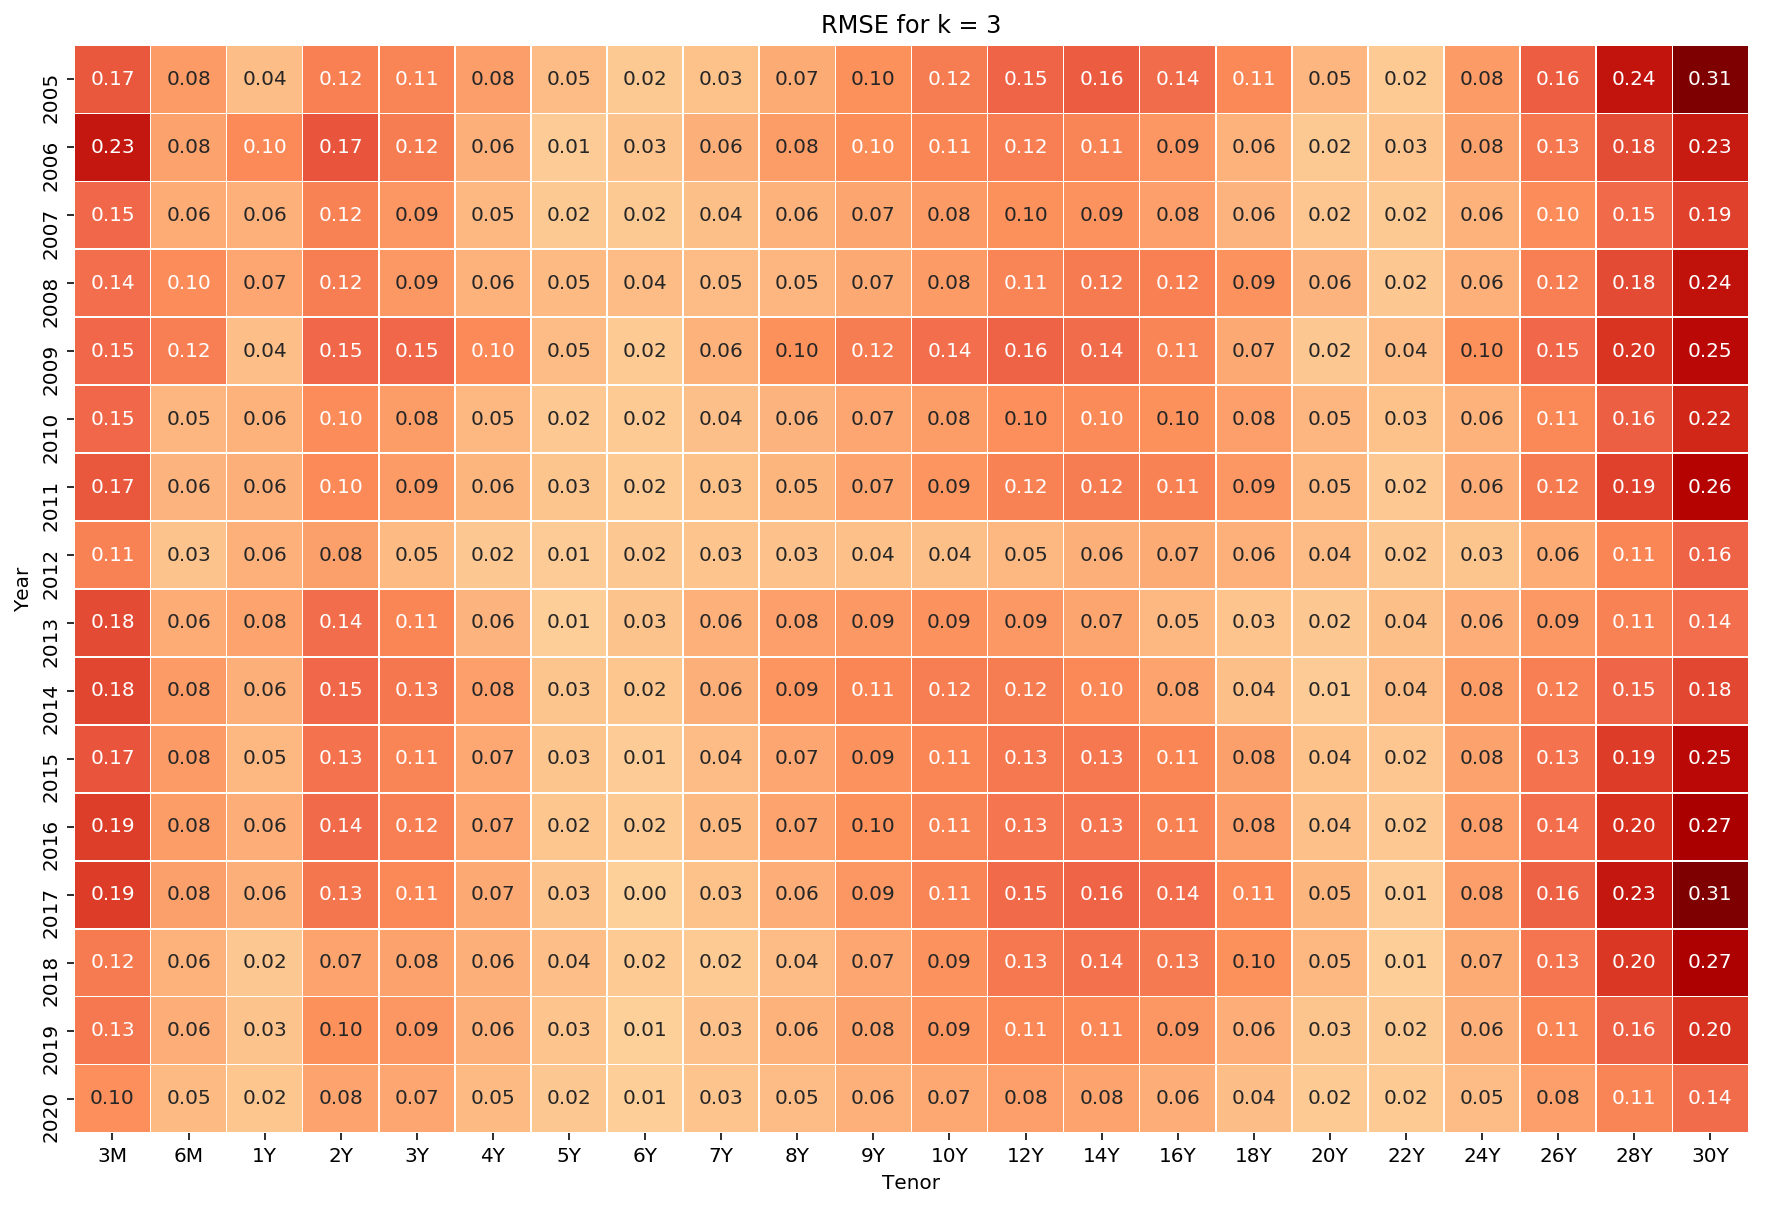

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(rmse_year, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("RMSE for k = "+str(k))
ax.set(xlabel="Tenor", ylabel="Year")
plt.show()

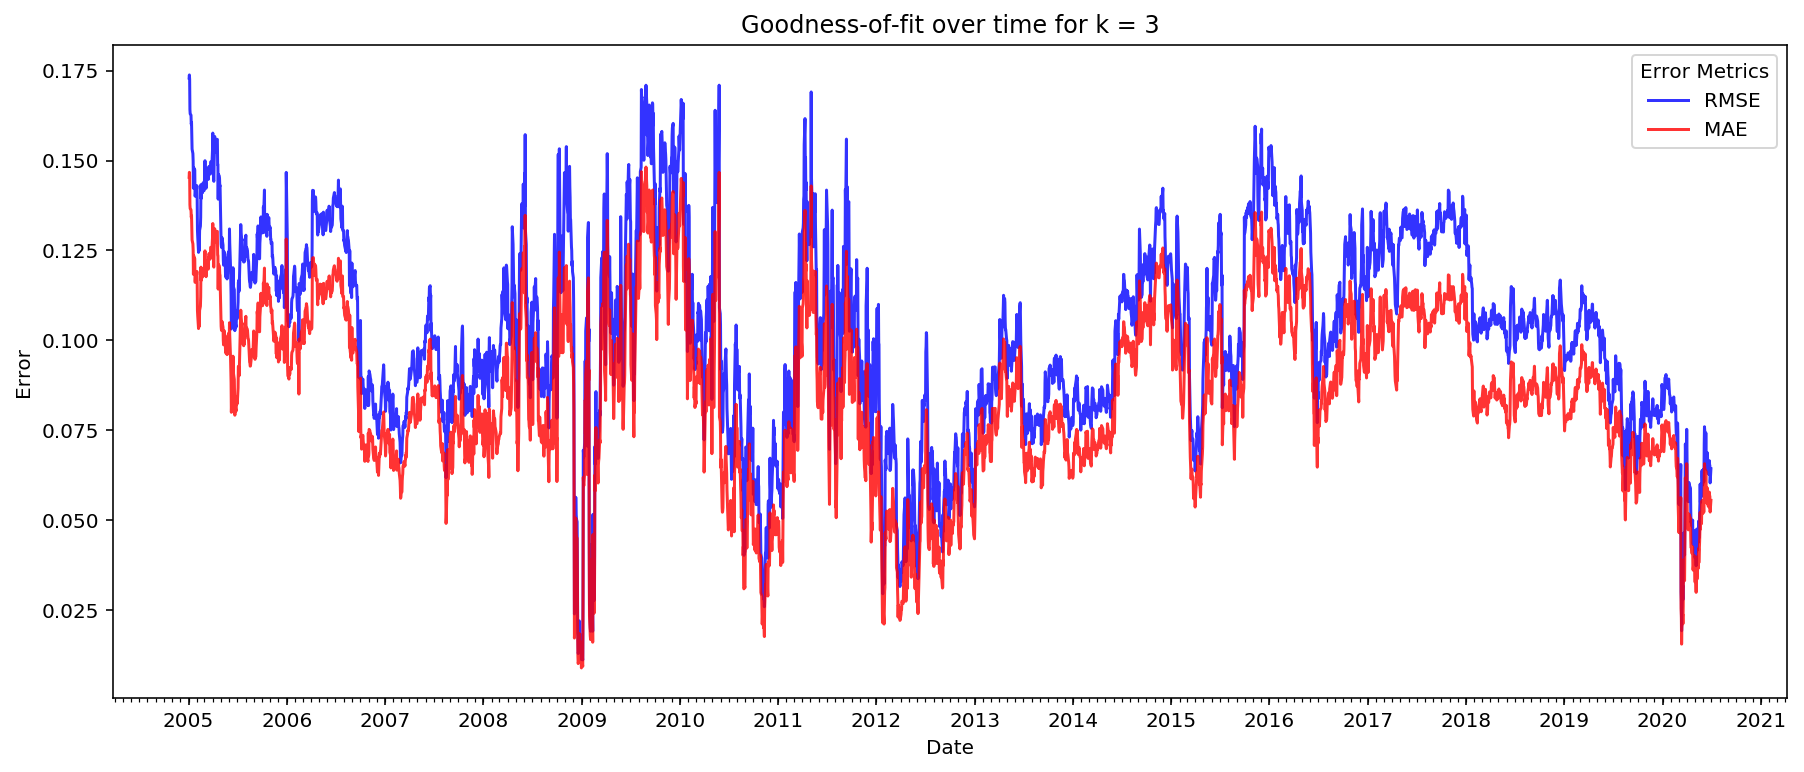

In [34]:
fig_5, ax = plt.subplots(1, 1, figsize = (15,6))

# Plots
ax.plot (rmse.iloc[:,0], c="blue", alpha = 0.8)
ax.plot (mae.iloc[:,0], c="red", alpha = 0.8)

# Format chart
ax.set_title ("Goodness-of-fit over time for k = "+ str(k))
ax.set_xlabel ("Date")
ax.set_ylabel ("Error")

# Format ticks
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.legend(title = "Error Metrics")

plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> Here i could investitage further on the individual observations with high error, how the yield curve moved, that the dimensionality reduced yields were not able to capture it.</div>

#### Correlation

In [35]:
pc_corr = pd.concat([spot, T_k], axis = 1)
pc_corr = pc_corr.corr()
pc_corr = pc_corr.iloc[:,-k:]
pc_corr

,PC_1,PC_2,PC_3
3M,-0.896880,0.429431,-0.098790
6M,-0.899479,0.429219,-0.078491
1Y,-0.914814,0.401630,-0.036001
2Y,-0.947245,0.317897,0.023567
3Y,-0.970244,0.234496,0.054211
4Y,-0.984690,0.159834,0.067470
5Y,-0.992968,0.094668,0.070177
6Y,-0.996975,0.038422,0.066420
7Y,-0.998093,-0.009726,0.058824
8Y,-0.997325,-0.050599,0.049141
